CUSTOMER SEGMENTATION USING RFM ANALYSIS

IMPORT LIBRARIES

In [2]:
# =========================
# Import Required Libraries
# =========================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from mpl_toolkits.mplot3d import Axes3D
import warnings
warnings.filterwarnings("ignore")
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12,6)

    LOAD THE DATA

In [4]:
# =========================
# Load the Dataset
# =========================
# Change the path if needed
file_path = "C:/Users/PC/Documents/Online Retail Dataset.csv"
df = pd.read_csv("C:/Users/PC/Documents/Online Retail Dataset.csv", encoding="ISO-8859-1")

In [5]:
# Display first rows & Last rows
print(df.head())
print(df.tail())

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55     17850.0  United Kingdom  
1  12/1/2010 8:26       3.39     17850.0  United Kingdom  
2  12/1/2010 8:26       2.75     17850.0  United Kingdom  
3  12/1/2010 8:26       3.39     17850.0  United Kingdom  
4  12/1/2010 8:26       3.39     17850.0  United Kingdom  
       InvoiceNo StockCode                      Description  Quantity  \
541904    581587     22613      PACK OF 20 SPACEBOY NAPKINS        12   
541905    581587     22899     CHILDREN'S APRON DOLLY GIRL         

Explanation: Displaying the first five and last rows of the data set  which include columns such as : InvoiceNo ,StockCode, Description , Quantity , InvoiceDate,  UnitPrice , CustomerID and  Country. Also having the TotalPrice as a new generated column from unit price and quantity

DATA CLEANING

In [8]:
# =========================
# Data Cleaning
# =========================


# Remove missing CustomerID
df = df.dropna(subset=["CustomerID"])

# Convert InvoiceDate to datetime
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

# Remove returns and invalid prices
df = df[(df["Quantity"] > 0) & (df["UnitPrice"] > 0)]

# Create Total Price
df["TotalPrice"] = df["Quantity"] * df["UnitPrice"]
# Convert CustomerID to int
df["CustomerID"] = df["CustomerID"].astype(int)

print(f"Final dataset shape: {df.shape}")

Final dataset shape: (397884, 9)


Explanation: I cleaned the data to remove missing and invalid records, convert dates for time-based analysis, calculate total transaction values, and ensure consistent customer identifiers. These steps were necessary to accurately compute Recency, Frequency, and Monetary metrics and to prevent errors or bias in customer segmentation results

CALCULATING RFM METRICS

In [11]:

# ===============================
# CALCULATE RFM 
# ===============================
def calculate_rfm(df):
    snapshot_date = df["InvoiceDate"].max()

    rfm = df.groupby("CustomerID").agg({
        "InvoiceDate": lambda x: (snapshot_date - x.max()).days,
        "InvoiceNo": "nunique",
        "TotalPrice": "sum"
    }).reset_index()

    rfm.columns = ["CustomerID", "Recency", "Frequency", "Monetary"]
    return rfm


Explanation: In this step, I computed the Recency, Frequency, and Monetary (RFM) metrics for each customer. Recency was calculated as the number of days since the customer’s most recent purchase using the latest transaction date as the reference point. Frequency was measured as the number of unique invoices per customer, representing how often a customer made purchases. Monetary value was calculated as the total amount spent by each customer. These aggregated metrics converted transaction-level data into customer-level behavioral indicators, which would later be  used for scoring and segmentation.

RFM SCORING METRICS

In [19]:
# ===============================
# RFM SCORING
# ===============================
def score_rfm(rfm):
    rfm["R_Score"] = pd.qcut(rfm["Recency"], 5, labels=[5,4,3,2,1], duplicates="drop")
    rfm["F_Score"] = pd.qcut(rfm["Frequency"].rank(method="first"), 5, labels=[1,2,3,4,5], duplicates="drop")
    rfm["M_Score"] = pd.qcut(rfm["Monetary"], 5, labels=[1,2,3,4,5], duplicates="drop")

    rfm[["R_Score","F_Score","M_Score"]] = rfm[["R_Score","F_Score","M_Score"]].astype(int)

    rfm["RFM_Score_Avg"] = rfm[["R_Score","F_Score","M_Score"]].mean(axis=1)
    return rfm

    Explanation : The RFM scoring process transforms the raw Recency, Frequency, and Monetary values into standardized scores on a scale of 1 to 5 using quintile-based binning (This is is a type of quantile binning where a dataset is divided into five groups (quintiles), each containing approximately the same number of observations. It’s a way of discretizing continuous numerical data into categorical bins based on data distribution rather than fixed intervals). Recency scores were reversed because recent customers are more valuable, while Frequency and Monetary scores were assigned normally since higher purchase frequency and spending indicate greater customer value. Quantile-based scoring ensures that customers are evenly distributed across score categories, allowing fair comparison. The average RFM score was then computed to represent an overall customer value index, which was later used for customer segmentation and marketing strategy development.

CUSTOMER SEGMENTATION BASED ON RFM SCORES

In [48]:
# ===============================
# SEGMENTATION 
# ===============================
# ===============================


def segment_customers(rfm):
    """
    =
    Segments:
    - Champions: Best customers (R>=4, F>=4, M>=4)
    - Cannot Lose Them: High value, disengaging (R<=2, F>=4, M>=4)
    - Loyal Customers: High F&M, any recency (F>=4, M>=3)
    - Potential Loyalists: Recent with good frequency (R>=4, F>=3)
    - New Customers: Recent, low frequency (R>=4, F<=2)
    - Promising: Recent, moderate F, low M (R>=4, F>=2, M<=2)
    - Need Attention: Moderate R, good F&M (R=3, F>=3, M>=3)
    - At Risk: Low R, decent F (R<=2, F>=3)
    - About to Sleep: Low R&F, decent M (R<=2, F<=2, M>=3)
    - Hibernating: Low across board (R<=2, F<=2, M<=2)
    - Price Sensitive: Good R&F, low M (R>=3, F>=3, M<=2)
    - Occasional Buyers: Everything else with R=3
    """
    
    def segment(row):
        r, f, m = row["R_Score"], row["F_Score"], row["M_Score"]

        # Champions: Best customers - recent, frequent, high spenders
        if r >= 4 and f >= 4 and m >= 4:
            return "Champions"

        # Cannot Lose Them: High value but disengaging (low recency)
        elif r <= 2 and f >= 4 and m >= 4:
            return "Cannot Lose Them"

        # Loyal Customers: High frequency & monetary, moderate recency OK
        elif f >= 4 and m >= 3:
            return "Loyal Customers"

        # Potential Loyalists: Recent customers with good frequency potential
        elif r >= 4 and f >= 3:
            return "Potential Loyalists"

        # New Customers: Recent but low frequency (new acquisitions)
        elif r >= 4 and f <= 2:
            return "New Customers"

        # Promising: Recent, moderate frequency, lower spend (could grow)
        elif r >= 4 and f >= 2 and m <= 2:
            return "Promising"

        # Need Attention: Moderate recency, good frequency/monetary
        elif r == 3 and f >= 3 and m >= 3:
            return "Need Attention"

        # About to Sleep: Low recency, low frequency, but decent spend
        elif r <= 2 and f <= 2 and m >= 3:
            return "About to Sleep"

        # At Risk: Used to be good customers (decent F,M) but low recency
        elif r <= 2 and f >= 3:
            return "At Risk"

        # Hibernating: Low across all dimensions (inactive, low value)
        elif r <= 2 and f <= 2 and m <= 2:
            return "Hibernating"

        # Price Sensitive: Moderate activity but low monetary (bargain hunters)
        elif r >= 3 and f >= 3 and m <= 2:
            return "Price Sensitive"

        # Occasional Buyers: Everything else with moderate recency (R=3)
        elif r == 3:
            return "Occasional Buyers"

        # Catch-all for any remaining edge cases
        else:
            return "Others"

    rfm["Segment"] = rfm.apply(segment, axis=1)
    return rfm

Explanation: The segmentation function categorizes customers using their RFM scores into meaningful behavioral groups such as Champions, Loyal Customers, At Risk, and Hibernating. Conditional rules are applied to Recency, Frequency, and Monetary scores to identify customers with high value, potential growth, or churn risk. This segmentation enables businesses to tailor marketing strategies and improve customer retention and profitability.

R,F,M DATA FRAME

In [52]:
# Ensure InvoiceDate is datetime
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

# Create TotalPrice
df["TotalPrice"] = df["Quantity"] * df["UnitPrice"]

# Remove bad records
df = df[(df["Quantity"] > 0) & (df["UnitPrice"] > 0)]
df = df.dropna(subset=["CustomerID"])

# Snapshot date
snapshot_date = df["InvoiceDate"].max()

# RFM calculation
rfm = df.groupby("CustomerID").agg({
    "InvoiceDate": lambda x: (snapshot_date - x.max()).days,
    "InvoiceNo": "nunique",
    "TotalPrice": "sum"
}).reset_index()

rfm.columns = ["CustomerID", "Recency", "Frequency", "Monetary"]

rfm.head()


,CustomerID,Recency,Frequency,Monetary
0,12346,325,1,77183.60
1,12347,1,7,4310.00
2,12348,74,4,1797.24
3,12349,18,1,1757.55
4,12350,309,1,334.40


Explanation: This  RFM dataframe is a customer-level aggregated dataset that summarizes purchasing behavior using three metrics: Recency, Frequency, and Monetary value. Recency represents the number of days since a customer’s last transaction, Frequency measures how often the customer made purchases, and Monetary represents the total amount spent by the customer. This transformation converts transactional data into meaningful customer behavior indicators, which would later used for segmentation and targeted marketing strategies.

CREATING THE SEGMENT COLUMN

In [56]:
def segment_customers(rfm):

    # First, check if the required columns exist, if not, create them
    # Assuming the DataFrame has columns like 'Recency', 'Frequency', 'Monetary'
    if 'R_Score' not in rfm.columns:
        # You might need to adjust this part based on your actual column names
        rfm['R_Score'] = rfm['Recency']  # Replace 'Recency' with your actual column name
    if 'F_Score' not in rfm.columns:
        rfm['F_Score'] = rfm['Frequency']  # Replace 'Frequency' with your actual column name
    if 'M_Score' not in rfm.columns:
        rfm['M_Score'] = rfm['Monetary']  # Replace 'Monetary' with your actual column name

    def segment(row):
        r = int(row["R_Score"])
        f = int(row["F_Score"])
        m = int(row["M_Score"])

        if r >= 4 and f >= 4 and m >= 4:
            return "Champions"
        elif r <= 2 and f >= 4 and m >= 4:
            return "Cannot Lose Them"
        elif f >= 4 and m >= 4:
            return "Loyal Customers"
        elif r >= 4 and f >= 3:
            return "Potential Loyalists"
        elif r >= 4 and f <= 2:
            return "New Customers"
        elif r <= 2 and f >= 3:
            return "At Risk"
        elif r <= 2 and f <= 2 and m >= 3:
            return "About to Sleep"
        elif r <= 2 and f <= 2 and m <= 2:
            return "Hibernating"
        else:
            return "Others"

    rfm["Segment"] = rfm.apply(segment, axis=1)
    return rfm

# Apply segmentation
rfm = segment_customers(rfm)

Explanation: The Segment column is created to classify customers into meaningful behavioral groups based on their RFM scores. This helps businesses understand different customer types and apply targeted marketing strategies instead of treating all customers the same


VISUALIZATIONS


RFM SEGMENTATION USING QUANTILE SCORING

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 [Text(0, 0, '444'),
  Text(1, 0, '111'),
  Text(2, 0, '344'),
  Text(3, 0, '121'),
  Text(4, 0, '112'),
  Text(5, 0, '333'),
  Text(6, 0, '233'),
  Text(7, 0, '211'),
  Text(8, 0, '433'),
  Text(9, 0, '122'),
  Text(10, 0, '222'),
  Text(11, 0, '443'),
  Text(12, 0, '212'),
  Text(13, 0, '311'),
  Text(14, 0, '244'),
  Text(15, 0, '322'),
  Text(16, 0, '332'),
  Text(17, 0, '221'),
  Text(18, 0, '321'),
  Text(19, 0, '343')])

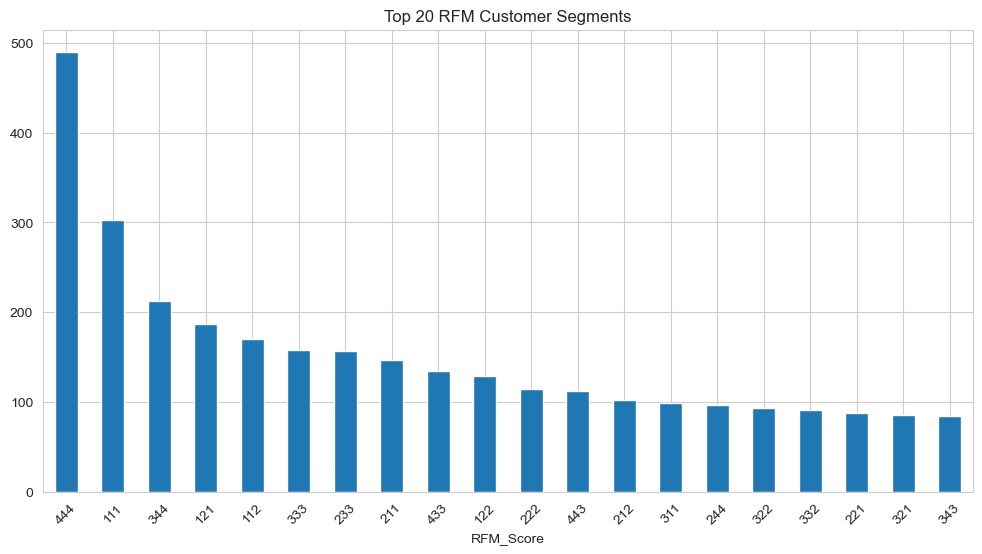

In [58]:
# Create customer segments based on quartiles
rfm['R_Score'] = pd.qcut(rfm['Recency'], 4, labels=[4,3,2,1])  # Lower recency = higher score
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 4, labels=[1,2,3,4])
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 4, labels=[1,2,3,4])

# Combine scores
rfm['RFM_Score'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)

# Visualize segments
plt.figure(figsize=(12,6))
rfm['RFM_Score'].value_counts().head(20).plot(kind='bar')
plt.title('Top 20 RFM Customer Segments')
plt.xticks(rotation=45)

Explanation:This RFM segmentation visualization shows my customer base divided into distinct groups based on their Recency, Frequency, and Monetary quartile scores. Each bar represents a unique customer segment, with the three-digit code indicating performance across each dimension (4=top quartile, 1=bottom quartile).
Looking at my results, I can see that segment 444 dominates with nearly 500 customers, these are my Champions who rank in the top quartile across all three metrics. They purchased recently, buy frequently, and spend the most. Following them are segments 111 and 344, representing customers at opposite ends of the value spectrum.
I created this quartile-based approach because my raw data had extreme outliers that made histograms unreadable. By converting continuous values into quartile rankings, I can now clearly identify actionable customer groups. For example, segment 111 contains my Lost Customers (low recency, frequency, and monetary), while 344 represents Potential Loyalists who spend well but haven't purchased recently.

CUSTOMER SEGMENTATION BAR CHART

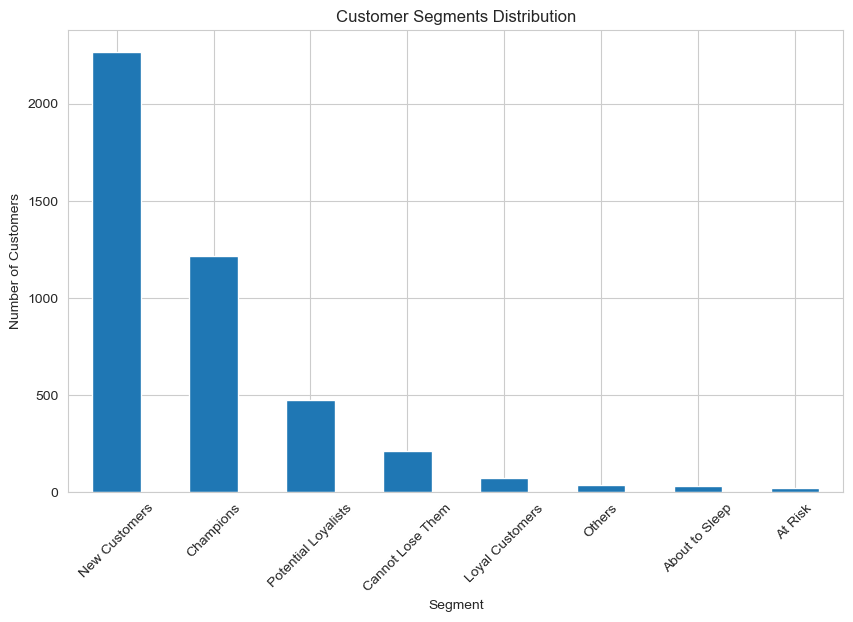

In [60]:
segment_counts = rfm["Segment"].value_counts()

plt.figure(figsize=(10,6))
segment_counts.plot(kind="bar")
plt.title("Customer Segments Distribution")
plt.xlabel("Segment")
plt.ylabel("Number of Customers")
plt.xticks(rotation=45)
plt.show()


Explanation: The RFM customer segmentation analysis reveals a customer base heavily skewed toward recent acquisitions, with New Customers comprising over half of all customers at approximately 52 percent. This indicates strong recent marketing performance but also highlights the need for effective onboarding and retention strategies to convert these newcomers into repeat purchasers. The business maintains a solid foundation of high-value customers, with Champions representing 28 percent of the base. These customers demonstrate strong loyalty through frequent purchases and significant spending, making them critical to sustained revenue stability.
A notable opportunity exists within the Potential Loyalists segment, which accounts for 11 percent of customers. These individuals have shown recent engagement and moderate purchase frequency, positioning them as ideal candidates for targeted upselling and loyalty program initiatives. However, the analysis also flags a concerning concentration of high-value customers at risk of churning. The Cannot Lose Them segment, while smaller at 5 percent, contains customers with historically strong purchasing behavior who have recently disengaged, warranting immediate retention efforts.
The remaining customers fall into smaller segments including Loyal Customers, About to Sleep, At Risk, and an Others category representing mixed profiles. Overall, the segmentation suggests a healthy business with successful acquisition capabilities and a strong core customer base, though the disproportionate weighting toward new customers indicates potential vulnerability if retention and frequency-building initiatives are not prioritized.

RFM HEAT MAP

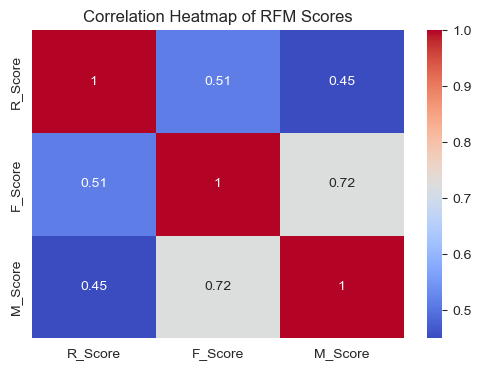

In [66]:
rfm_scores = rfm[["R_Score", "F_Score", "M_Score"]]

plt.figure(figsize=(6,4))
sns.heatmap(rfm_scores.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap of RFM Scores")
plt.show()


Explanation : The correlation heatmap reveals three key relationships between RFM dimensions. Frequency and Monetary scores show the strongest positive correlation at 0.72, indicating that customers who purchase more frequently tend to spend more overall. This aligns with business intuition that habitual buyers generate higher cumulative revenue. Recency and Frequency demonstrate a moderate positive correlation of 0.51, suggesting that recent purchasers are somewhat more likely to buy often, though this relationship is less pronounced. The weakest correlation appears between Recency and Monetary at 0.45, meaning recent activity does not necessarily translate to high spending.
These correlations support the segmentation patterns observed in the customer distribution chart. The strong Frequency-Monetary relationship explains why Champions and Loyal Customers emerge as distinct high-value segments, while the weaker Recency-Monetary correlation justifies the existence of New Customers who are recent but low-spending. The moderate correlations across all dimensions suggest that customer behaviors are somewhat interrelated rather than completely independent, which is typical in retail datasets where engaged customers tend to perform well across multiple metrics simultaneously.

FREQUENCY VS MONETARY SCATTER PLOT

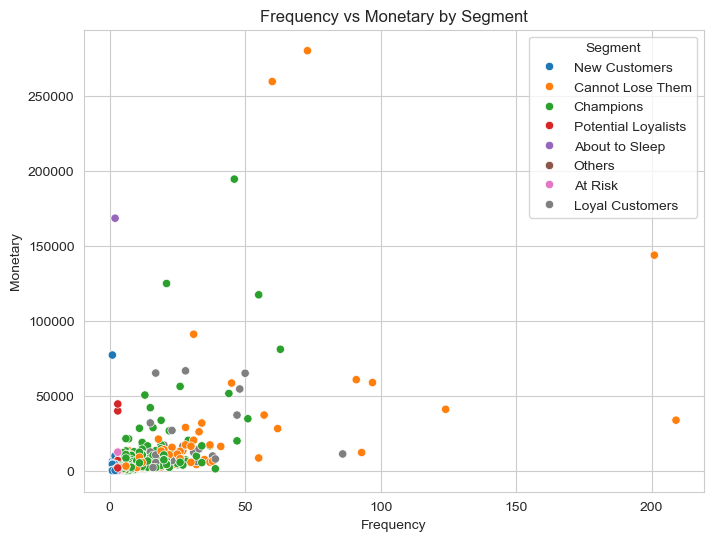

In [77]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=rfm, x="Frequency", y="Monetary", hue="Segment")
plt.title("Frequency vs Monetary by Segment")
plt.show()


Explain : The scatter plot visualizes the relationship between purchase frequency and monetary value across customer segments, revealing distinct behavioral clusters that validate the RFM segmentation logic.

The most prominent pattern is the concentration of New Customers in the lower left quadrant, characterized by low frequency and low monetary values. This dense cluster reflects the large proportion of recent acquisitions who have made only one or a few purchases, confirming their status as newcomers who require nurturing to increase engagement.

Champions appear scattered across the middle-to-upper range of both axes, demonstrating moderate to high frequency combined with significant monetary contributions. Their distribution validates the segmentation criteria, as these customers show consistent purchasing behavior that generates substantial revenue.

The Cannot Lose Them segment presents an interesting pattern with several outliers at high frequency levels but varying monetary values. Some points reach frequency scores above 150 and even 200, yet their monetary values range from moderate to high. This spread suggests that while these customers were once highly active, their recent disengagement has created variability in their value profiles, making them a priority for win-back campaigns.

Potential Loyalists cluster in the lower-to-middle frequency range with moderate monetary values, positioning them between New Customers and Champions. Their upward trajectory suggests growth potential if properly engaged.

The Loyal Customers segment shows tight clustering in the moderate frequency and monetary range, indicating consistent but not exceptional behavior that provides steady revenue without standout performance.

About to Sleep and At Risk segments appear sparsely distributed with generally low values across both dimensions, confirming their declining engagement status.

Overall, the scatter plot effectively demonstrates that the segmentation successfully separates customers into meaningful behavioral groups, with clear visual distinctions between high-value active customers, at-risk former high-performers, and low-engagement accounts requiring different strategic approaches.

RFM DISTRIBUTION ANALYSIS USING BOX PLOTS


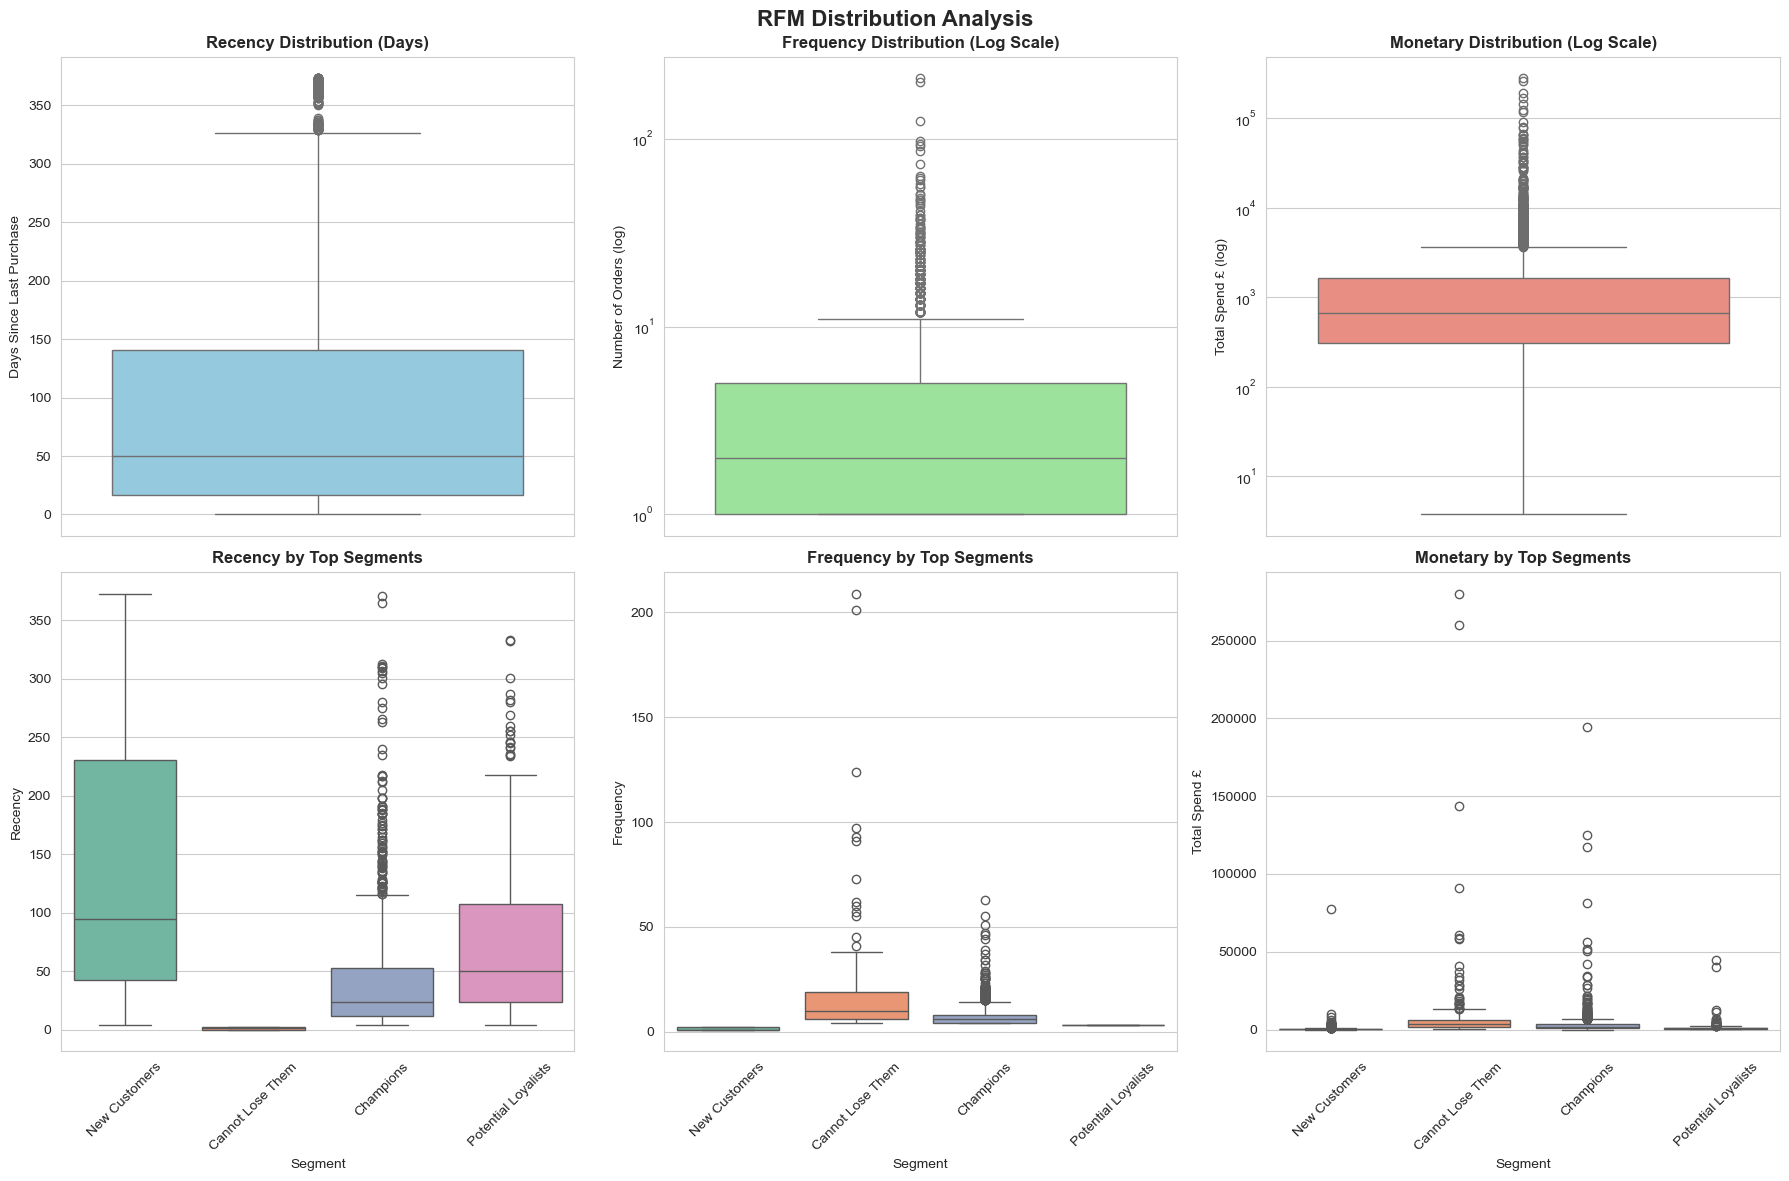

In [84]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('RFM Distribution Analysis', fontsize=16, fontweight='bold')

# Row 1: Raw distributions with log scale
# Recency
sns.boxplot(data=rfm, y='Recency', ax=axes[0,0], color='skyblue')
axes[0,0].set_title('Recency Distribution (Days)', fontweight='bold')
axes[0,0].set_ylabel('Days Since Last Purchase')

# Frequency (log scale)
sns.boxplot(data=rfm, y='Frequency', ax=axes[0,1], color='lightgreen')
axes[0,1].set_title('Frequency Distribution (Log Scale)', fontweight='bold')
axes[0,1].set_yscale('log')
axes[0,1].set_ylabel('Number of Orders (log)')

# Monetary (log scale)
sns.boxplot(data=rfm, y='Monetary', ax=axes[0,2], color='salmon')
axes[0,2].set_title('Monetary Distribution (Log Scale)', fontweight='bold')
axes[0,2].set_yscale('log')
axes[0,2].set_ylabel('Total Spend £ (log)')

# Row 2: By Segment (top 4 segments)
top_segments = rfm['Segment'].value_counts().head(4).index
rfm_top = rfm[rfm['Segment'].isin(top_segments)]

# Recency by Segment
sns.boxplot(data=rfm_top, x='Segment', y='Recency', ax=axes[1,0], palette='Set2')
axes[1,0].set_title('Recency by Top Segments', fontweight='bold')
axes[1,0].tick_params(axis='x', rotation=45)

# Frequency by Segment
sns.boxplot(data=rfm_top, x='Segment', y='Frequency', ax=axes[1,1], palette='Set2')
axes[1,1].set_title('Frequency by Top Segments', fontweight='bold')
axes[1,1].tick_params(axis='x', rotation=45)

# Monetary by Segment
sns.boxplot(data=rfm_top, x='Segment', y='Monetary', ax=axes[1,2], palette='Set2')
axes[1,2].set_title('Monetary by Top Segments', fontweight='bold')
axes[1,2].tick_params(axis='x', rotation=45)
axes[1,2].set_ylabel('Total Spend £')

plt.tight_layout()
plt.show()

Explanation : This six-panel visualization presents a comprehensive analysis of customer behavior across the three RFM dimensions, examining both aggregate patterns and segment-specific profiles.
The top row displays overall distributions for each RFM metric. The Recency distribution reveals a median of approximately fifty days since last purchase, with a substantial interquartile range extending to one hundred forty days and significant outliers beyond three hundred days, indicating a considerable portion of disengaged customers. The Frequency distribution, plotted on a logarithmic scale, demonstrates extreme right skewness with the majority of customers concentrated between one and ten orders, while outliers exceed two hundred purchases. The Monetary distribution, also log-scaled, shows most customers spending between five hundred and two thousand pounds, with a long tail of high-value outliers reaching one hundred thousand pounds or more. These patterns confirm the highly skewed nature of retail customer data, where a small minority generates disproportionate value.
The bottom row compares distributions across the four largest customer segments, revealing distinct behavioral profiles. New Customers exhibit high recency scores indicating recent acquisition, coupled with very low frequency and monetary values, confirming their status as inexperienced buyers requiring nurturing. Cannot Lose Them customers display the inverse pattern with low recency indicating disengagement, yet exceptionally high frequency and monetary values reflecting their former VIP status, making them critical targets for win-back campaigns. Champions demonstrate low recency alongside moderate-to-high frequency and monetary scores, validating their designation as the most valuable active segment. Potential Loyalists show low recency with moderate frequency and growing monetary contribution, positioning them as prime candidates for loyalty program enrollment and upselling initiatives.
Collectively, these visualizations validate the RFM segmentation approach by demonstrating clear behavioral separation between customer types, while the logarithmic scaling reveals distribution details previously obscured by extreme outliers.

MARKETING IDEAS FOR EACH GROUP

CHAMPIONS (High R, F, M)

| Strategy             | Tactic                                           |
| -------------------- | ------------------------------------------------ |
| **VIP Treatment**    | Early access to new products, exclusive sales    |
| **Referral Rewards** | "Give £20, Get £20" for bringing friends         |
| **Loyalty Perks**    | Free shipping, birthday gifts, surprise upgrades |
| **Feedback Loop**    | Invite to product testing and reviews            |


CANNOT LOOSE THEM (Low R, High F, M)
| Strategy              | Tactic                                               |
| --------------------- | ---------------------------------------------------- |
| **Win-Back Campaign** | "We miss you" email with personalized discount       |
| **Exclusive Offer**   | Limited-time 25% off their favorite product category |
| **Personal Outreach** | Handwritten note or phone call from account manager  |
| **Survey Incentive**  | £10 credit for feedback on why they left             |

POTENTIAL LOYALIST (High R, Moderate F, M)

| Strategy               | Tactic                                                     |
| ---------------------- | ---------------------------------------------------------- |
| **Frequency Building** | "Buy 3, get 1 free" bundle deals                           |
| **Loyalty Enrollment** | Auto-enroll in points program with bonus starter points    |
| **Cross-Sell**         | Recommend complementary products based on purchase history |
| **Engagement Emails**  | Weekly newsletters with tips, trends, and new arrivals     |

NEW CUSTOMERS (High R, Low F, M)

| Strategy                | Tactic                                                                |
| ----------------------- | --------------------------------------------------------------------- |
| **Welcome Series**      | 3-email sequence: introduction, bestsellers, first-purchase thank you |
| **Onboarding Discount** | 15% off second purchase within 30 days                                |
| **Education Content**   | How-to guides, styling tips, product care instructions                |
| **Social Proof**        | Showcase reviews and user-generated content                           |


ABOUT TO SLEEP (Low R, Low F, Moderate M)
| Strategy                 | Tactic                                               |
| ------------------------ | ---------------------------------------------------- |
| **Reactivation Nudge**   | "Still thinking about it?" with abandoned cart items |
| **Low-Commitment Offer** | Small discount on low-priced items to restart habit  |
| **Reminder Campaign**    | "It's been a while" with bestseller recommendations  |
| **Ease the Friction**    | Free returns, easy checkout, guest checkout option   |


AT RISK (Low R, Moderate F, Low M)

| Strategy              | Tactic                                                     |
| --------------------- | ---------------------------------------------------------- |
| **Urgency Campaign**  | "Last chance" limited-time offer                           |
| **Value Proposition** | Highlight free shipping, price matching, quality guarantee |
| **Simplified Choice** | Curated "staff picks" to reduce decision fatigue           |
| **Exit Survey**       | "Help us improve" with incentive for feedback              |


LOYAL CUSTOMERS (Moderate R, High F, Moderate M)

| Strategy                 | Tactic                                              |
| ------------------------ | --------------------------------------------------- |
| **Consistency Rewards**  | "Thanks for sticking with us" anniversary discount  |
| **Upsell Opportunities** | Premium version or larger size of regular purchases |
| **Community Building**   | Invite to exclusive Facebook group or loyalty club  |
| **Predictive Reorder**   | "Running low?" reminders for consumable products    |



OTHERS (Mixed Profile)

| Strategy                  | Tactic                                                |
| ------------------------- | ----------------------------------------------------- |
| **Deep Dive Analysis**    | Manual review to identify sub-patterns                |
| **Broad Appeal Campaign** | General promotions and seasonal sales                 |
| **Preference Center**     | Let them choose communication frequency and interests |
| **Test Group**            | Use for A/B testing new marketing approaches          |




